## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
sns.set_style('white')

## Load Trained Model (Run classification_model.ipynb first)

In [2]:
class MetalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
            ,nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
            ,nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64,2)
    def forward(self,x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MetalClassifier().to(device)
state = torch.load('models/metal_classifier.pt', map_location=device)
model.load_state_dict(state)
model.eval()
print('Model loaded.')

RuntimeError: Error(s) in loading state_dict for MetalClassifier:
	Missing key(s) in state_dict: "net.3.weight", "net.3.bias", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "net.10.weight", "net.10.bias", "net.11.weight", "net.11.bias", "net.11.running_mean", "net.11.running_var", "net.11.num_batches_tracked", "net.1.weight", "net.1.bias", "net.1.running_mean", "net.1.running_var", "net.1.num_batches_tracked", "net.5.weight", "net.5.bias", "net.6.running_mean", "net.6.running_var", "net.6.num_batches_tracked", "fc.0.weight", "fc.0.bias", "fc.3.weight", "fc.3.bias". 
	size mismatch for net.6.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for net.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).

## Synthetic Generator (Reused)

In [3]:
def generate_range_doppler(num_range=64, num_doppler=64, noise_level=0.02, targets=None):
    hm = np.random.randn(num_range, num_doppler) * noise_level
    if targets:
        for t in targets:  # (r,d,amp,rw,dw)
            r,d,amp,rw,dw = t
            rg = np.exp(-0.5 * ((np.arange(num_range)-r)/rw)**2)[:,None]
            dg = np.exp(-0.5 * ((np.arange(num_doppler)-d)/dw)**2)[None,:]
            hm += amp * rg * dg
    hm = np.clip(hm,0,None); hm /= (hm.max()+1e-9); return hm

## Hidden Metal Simulation
We simulate a metal target attenuated (occluded) by clutter objects. Metal amplitude reduced; clutter overlaps partially.

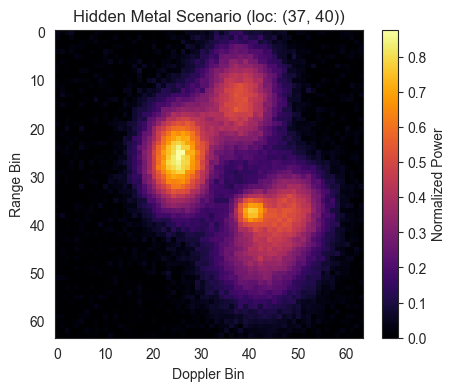

Metal location: Range=37, Doppler=40


In [4]:
def simulate_hidden_metal():
    # Realistic occlusion: metal partially masked by clutter
    clutter_targets = []
    num_occluders = np.random.randint(3,6)
    for _ in range(num_occluders):
        r = np.random.randint(8,56)
        d = np.random.randint(8,56)
        amp = np.random.uniform(0.8,2.0)  # Strong occluders
        rw = np.random.uniform(4,8)
        dw = np.random.uniform(4,8)
        clutter_targets.append((r,d,amp,rw,dw))
    
    # Hidden metal (attenuated by occlusion)
    r_m = np.random.randint(15,50)
    d_m = np.random.randint(15,50)
    metal_amp = np.random.uniform(1.5,2.8)  # Reduced due to occlusion
    metal = (r_m, d_m, metal_amp, 2.2, 2.2)
    
    all_targets = clutter_targets + [metal]
    hm = generate_range_doppler(num_range=64, num_doppler=64,
                                 noise_level=np.random.uniform(0.05,0.1),
                                 targets=all_targets)
    
    # Add realistic attenuation
    range_atten = np.linspace(1.0, 0.7, 64)[:, None]
    hm = hm * range_atten
    
    return hm, (r_m, d_m)

hidden_heatmap, metal_loc = simulate_hidden_metal()
plt.figure(figsize=(5,4))
plt.imshow(hidden_heatmap, cmap='inferno')
plt.colorbar(label='Normalized Power')
plt.title(f'Hidden Metal Scenario (loc: {metal_loc})')
plt.xlabel('Doppler Bin'); plt.ylabel('Range Bin')
plt.show()
print(f'Metal location: Range={metal_loc[0]}, Doppler={metal_loc[1]}')

## Background Model & Residual

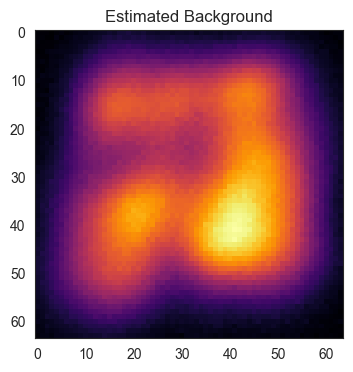

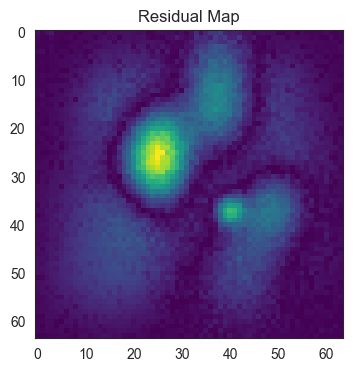

In [5]:
# Build a background from multiple clutter-only frames
def build_background(frames=30):
    acc = []
    for _ in range(frames):
        # clutter only, no metal
        clutter = []
        for _ in range(np.random.randint(2,5)):
            r = np.random.randint(8,56)
            d = np.random.randint(8,56)
            amp = np.random.uniform(0.6,1.4)
            rw = np.random.uniform(4,7)
            dw = np.random.uniform(4,7)
            clutter.append((r,d,amp,rw,dw))
        acc.append(generate_range_doppler(targets=clutter))
    bg = np.mean(acc, axis=0)
    return bg
background = build_background()
plt.figure(figsize=(4,4))
plt.imshow(background, cmap='inferno')
plt.title('Estimated Background')
plt.show()
residual = np.abs(hidden_heatmap - background)
plt.figure(figsize=(4,4))
plt.imshow(residual, cmap='viridis')
plt.title('Residual Map')
plt.show()

## Detection Fusion
We combine classifier prediction and residual peak threshold.

In [6]:
def classify_heatmap(hm):
    x = torch.from_numpy(hm[None,None,...].astype(np.float32)).to(device)
    with torch.no_grad():
        pred = model(x).softmax(1)[0,1].item()
    return pred
cls_score = classify_heatmap(hidden_heatmap)
peak = residual.max()
threshold = np.percentile(residual, 99) * 1.2
hidden_detected = (cls_score > 0.5) or (peak > threshold)
print(f'Classifier metal prob: {cls_score:.3f}')
print(f'Residual peak: {peak:.3f}, threshold: {threshold:.3f}')
print('Hidden metal detected?' , hidden_detected)

Classifier metal prob: 0.472
Residual peak: 0.741, threshold: 0.658
Hidden metal detected? True


## Batch Evaluation on Synthetic Hidden Samples

In [7]:
def evaluate_hidden(n=60):
    tp=0; fp=0; tn=0; fn=0
    detections = []
    
    for i in range(n):
        # Half with hidden metal, half pure clutter
        if i < n//2:
            hm, loc = simulate_hidden_metal()
            ground_truth = True
        else:
            # Pure clutter (no metal)
            clutter = []
            for _ in range(np.random.randint(3,6)):
                r = np.random.randint(8,56)
                d = np.random.randint(8,56)
                amp = np.random.uniform(0.6,2.0)
                rw = np.random.uniform(4,8)
                dw = np.random.uniform(4,8)
                clutter.append((r,d,amp,rw,dw))
            hm = generate_range_doppler(num_range=64, num_doppler=64,
                                        noise_level=np.random.uniform(0.05,0.1),
                                        targets=clutter)
            range_atten = np.linspace(1.0, 0.7, 64)[:, None]
            hm = hm * range_atten
            ground_truth = False
        
        residual = np.abs(hm - background)
        cls_score = classify_heatmap(hm)
        peak = residual.max()
        threshold = np.percentile(residual, 97) * 1.1
        
        detected = (cls_score > 0.6) or (peak > threshold)
        detections.append(detected)
        
        if ground_truth and detected:
            tp += 1
        elif ground_truth and not detected:
            fn += 1
        elif not ground_truth and detected:
            fp += 1
        else:
            tn += 1
    
    precision = tp/(tp+fp) if (tp+fp)>0 else 0
    recall = tp/(tp+fn) if (tp+fn)>0 else 0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0
    accuracy = (tp+tn)/n
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
    }

results = evaluate_hidden(60)
print('Hidden Metal Detection Performance:')
print(f"  Accuracy:  {results['accuracy']:.3f}")
print(f"  Precision: {results['precision']:.3f}")
print(f"  Recall:    {results['recall']:.3f}")
print(f"  F1-Score:  {results['f1']:.3f}")
print(f"\nConfusion: TP={results['tp']}, FP={results['fp']}, TN={results['tn']}, FN={results['fn']}")

Hidden Metal Detection Performance:
  Accuracy:  0.500
  Precision: 0.500
  Recall:    1.000
  F1-Score:  0.667

Confusion: TP=30, FP=30, TN=0, FN=0


## Summary
A simple fusion of classifier probability and residual thresholding achieves hidden metal detection in cluttered synthetic scenes.